# <font color=blue>Mean Machine - Ridge Regression (gradient descent)<font>

In this notebook, we will implement ridge regression via gradient descent:
* write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# 1: Set the path that includes all relevant files

In [1]:
import os                                               # 操作系统用来管理文件路径
os.chdir("C:\Users\stevenwsy\Desktop\Steven - Python")  # 将路径改为 "C:\Users\stevenwsy\Desktop\Steven - Python"

# 注意：你们要把 "C:\Users\stevenwsy\Desktop\Steven - Python" 改成在你们电脑里面的路径

# 2: Import all relevant packages

In [2]:
import numpy as np     # 用来做数学运算
import pandas as pd    # 用来处理数据表

# 将所有图都在 Notebook 里显示
%matplotlib inline               
import matplotlib.pyplot as plt  # 用来画图

from sklearn.cross_validation import train_test_split     # 做交叉验证，划分训练集和测试集

# 3: Load house sales data

In [3]:
sales = pd.read_csv('kc_house_data.csv')
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# 4. Basic functions

In [4]:
def get_numpy_data( dataframe, features, output ):
    df = dataframe.copy()
    df['constant'] = 1 # this is how you add a constant column to a dataframe
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the dataframe df (now including constant):
    features_df = df[features]
    # the following line will convert the features_df into a numpy matrix
    input_matrix = features_df.as_matrix()
    # assign the column of df associated with the output to the output_df
    output_df = df[output]
    # the following will convert the output_df into a numpy array
    output_array = output_df.as_matrix()
    return (input_matrix, output_array)

In [5]:
def predict_output( input_matrix, weights ):
    predictions = np.dot( input_matrix, weights )
    return predictions

# 5: Ridge regression with gradient descent

## <font color=red>5.1. Computing the Derivative<font>

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2)
```

As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
SUM[ error*[feature_i] ]
```
The derivative of the regularization term with respect to `w[i]` is:
```
l2_penalty*w[i]
```
Summing both, we get
```
SUM[ error*[feature_i] ] + l2_penalty*w[i]
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times product of the error and the feature itself, plus `l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just the sum of the errors (without the `l2_penalty*w[0]` term).

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [6]:
def feature_derivative_ridge( errors, feature, weight, l2_penalty, feature_is_constant ):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2*np.dot( feature.T, errors )
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2*np.dot( feature.T, errors ) + 2*l2_penalty*weight
    return derivative

To test your feature derivartive run the following:

In [7]:
( example_features, example_output ) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output( example_features,my_weights ) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge( errors, example_features[:,1], my_weights[1], 1, False )
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge( errors, example_features[:,0], my_weights[0], 1, True )
print np.sum(errors)*2.

-5.6569296281e+13
-5.6569296281e+13

-22450813310.0
-22450813310.0


## <font color=red>5.2. Gradient Descent<font>

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [8]:
def ridge_regression_gradient_descent( input_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100 ):
    weights = np.array(initial_weights) # make sure it's a numpy array
    counter = 1
    #while not reached maximum number of iterations:
    while counter <= max_iterations:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output( input_matrix, weights )
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge( errors, input_matrix[:, i], weights[i], l2_penalty, feature_is_constant )
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i]-step_size*derivative   
        counter += 1
    return weights

## <font color=red>5.4. Single variable ridge regression<font>

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [9]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [10]:
(train_data, test_data) = train_test_split(sales, train_size=0.8, random_state=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [11]:
( simple_feature_matrix, output ) = get_numpy_data( train_data, simple_features, my_output )
( simple_test_feature_matrix, test_output ) = get_numpy_data( test_data, simple_features, my_output )

Let's set the parameters for our optimization:

In [12]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_zero_penalty`

we'll use them later.

In [13]:
l2_penalty = 0.0
simple_weights_zero_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, 
                                                                step_size, l2_penalty, max_iterations)

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [14]:
l2_penalty = 1e11
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, 
                                                                step_size, l2_penalty, max_iterations)

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

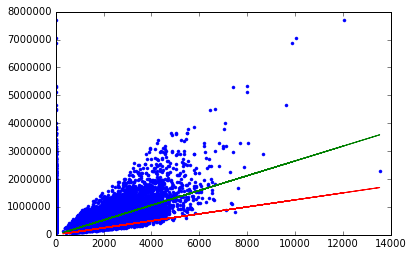

In [15]:
plt.plot(simple_feature_matrix,output,'b.',
         simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_zero_penalty), 'g-',
         simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_high_penalty), 'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

In [16]:
RSS1 = ((test_output - predict_output(simple_test_feature_matrix, initial_weights))**2).sum()
RSS2 = ((test_output - predict_output(simple_test_feature_matrix, simple_weights_zero_penalty))**2).sum()
RSS3 = ((test_output - predict_output(simple_test_feature_matrix, simple_weights_high_penalty))**2).sum()

In [17]:
print 'The weights for zero penalty are', simple_weights_zero_penalty
print 'The weights for high penalty are', simple_weights_high_penalty

The weights for zero penalty are [ -1.69670510e-01   2.64662272e+02]
The weights for high penalty are [   9.79250825  125.10164063]


In [18]:
print 'The RSS for initial zero weights is', RSS1
print 'The RSS for zero penalty is', RSS2
print 'The RSS for high penalty is', RSS3

The RSS for initial zero weights is 1.72611062907e+15
The RSS for zero penalty is 2.68116744355e+14
The RSS for high penalty is 6.51316863974e+14


## <font color=red>5.4. Multiple variable ridge regression<font>

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [19]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
( feature_matrix, output ) = get_numpy_data( train_data, model_features, my_output )
( test_feature_matrix, test_output ) = get_numpy_data( test_data, model_features, my_output )

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [20]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_zero_penalty`

In [21]:
l2_penalty = 0.0
multiple_weights_zero_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                                  step_size, l2_penalty, max_iterations)

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [22]:
l2_penalty = 1e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, 
                                                                  step_size, l2_penalty, max_iterations)

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

In [23]:
RSS1 = ((test_output - predict_output(test_feature_matrix, initial_weights))**2).sum()
RSS2 = ((test_output - predict_output(test_feature_matrix, multiple_weights_zero_penalty))**2).sum()
RSS3 = ((test_output - predict_output(test_feature_matrix, multiple_weights_high_penalty))**2).sum()

In [24]:
print 'The weights for zero penalty are', multiple_weights_zero_penalty
print 'The weights for high penalty are', multiple_weights_high_penalty

The weights for zero penalty are [  -0.36225644  245.25122504   21.79589459]
The weights for high penalty are [  6.76377951  91.95872007  78.76627044]


In [25]:
print 'The RSS for initial zero weights is', RSS1
print 'The RSS for zero penalty is', RSS2
print 'The RSS for high penalty is', RSS3

The RSS for initial zero weights is 1.72611062907e+15
The RSS for zero penalty is 2.66382070234e+14
The RSS for high penalty is 4.6330678298e+14


Predict the house price for the 1st house in the test set using the no regularization and high regularization models.

In [26]:
prediction = predict_output( test_feature_matrix, multiple_weights_zero_penalty )
print 'The price of 1st house is',  test_output[0], 'while its prediction is', prediction[0]

The price of 1st house is 297000.0 while its prediction is 381877.018822


In [27]:
prediction = predict_output( test_feature_matrix, multiple_weights_high_penalty )
print 'The price of 1st house is',  test_output[0], 'while its prediction is', prediction[0]

The price of 1st house is 297000.0 while its prediction is 244143.500208
